**CARICAMENTO DATASET**

Il dataset è composto da due file csv:
- musae_PTBR_edges: file contenente gli archi tra i nodi del grafo;
- musea_PTBR_target: file contenente gli attributi di ciascun nodo;

In [1]:
import pandas as pd

# Caricamento file
edges = pd.read_csv('/kaggle/input/dataset-twitch/twitch/PTBR/musae_PTBR_edges.csv')
features = pd.read_csv('/kaggle/input/dataset-twitch/twitch/PTBR/musae_PTBR_target.csv')

print(edges.head())
print(features.head())

   from    to
0     0    92
1     0   428
2     1   689
3     1  1147
4     1  1666
          id  days  mature   views  partner  new_id
0   44891403  1943   False  929459     True    1706
1   61180621  1633   False   11194    False    1273
2  145109685   632   False    2850    False     313
3  122121521   906    True    3422    False    1570
4  189445819   267   False      71    False     800


**CREAZIONE GRAFO**

In [2]:
import networkx as nx

#Creazione di un grafo vuoto
G = nx.Graph()

#Aggiunta degli archi al grafo
for i,r in edges.iterrows():
     G.add_edge(r['from'], r['to'])

print(f"|V|={G.number_of_nodes()}")
print(f"|E|={G.number_of_edges()}")

|V|=1912
|E|=31299


È stato creato un grafo non orientato G=(V,E) con un numero di nodi |V|=168114 e un numero di archi |E|=6797557. A questo punto, procediamo con il calcolo di alcune misure per il grafo appena costruito.

Di seguito viene mostrata la distribuzione dei gradi dei nodi del grafo appena creato

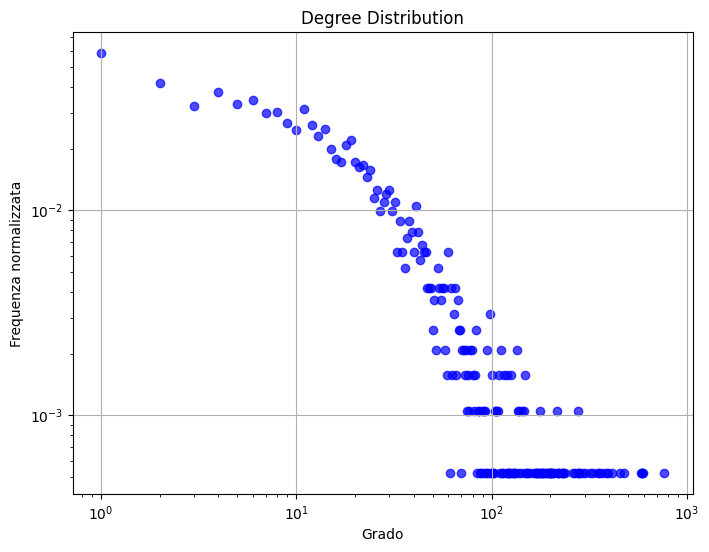

In [6]:
import matplotlib.pyplot as plt
from collections import Counter

#calcolo del grado di ciascun nodo
node_degrees = dict(G.degree()) 

#conteggio delle frequenze dei gradi
degree_count = Counter(node_degrees.values())
degrees = list(degree_count.keys())
frequencies = list(degree_count.values())

#normalizzazione delle frequenze rispetto al numero di nodi
total_nodes = len(G.nodes())
normalized_frequencies = [freq / total_nodes for freq in frequencies]

#visualizzazione della power law
plt.figure(figsize=(8, 6))
plt.scatter(degrees, normalized_frequencies, color="blue", alpha=0.7)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Grado")
plt.ylabel("Frequenza normalizzata")
plt.title("Degree Distribution")
plt.grid(True)
plt.show()

D'altra parte, sono mostrate una serie di misure calcolate sul grafo per capire generalmente la struttura del grafo.

In [30]:
#transitività
transitivity = nx.transitivity(G)
print(f"transitività = {transitivity}")

transitività = 0.1309809619261169


In [31]:
#average clustering
average_clustering = nx.average_clustering(G)
print(f"clustering medio = {average_clustering}")

clustering medio = 0.3198952746693515


In [32]:
#numero di bridge
bridges = list(nx.bridges(G))
print(f"numero di bridge: {len(bridges)}")

numero di bridge: 116


In [5]:
#lunghezza media dei cammini
avg_length = nx.average_shortest_path_length(G)
print(f"lunghezza media cammini = {avg_length}")

lunghezza media cammini = 2.5323791570055767


In [33]:
#densità
print(f"densità = {nx.density(G)}")

densità = 0.017132150575067492


Dalle misure appena calcolate possiamo fare delle deduzioni sulla struttura del grafo preso in considerazione:
- per quanto riguarda la transitività, un valore basso indica il grafo non possiede una forte coesione globale e che, quindi, il grafo potrebbe essere suddiviso in più componenti;
- per quanto riguarda il clustering, il valore ottenuto suggerisce una tendenza bassa alla formazioni di cluster;
- per quanto riguarda la lunghezza dei cammini più corti, il valore basso indica che i nodi sono relativamente vicini tra loro.
- infine, per quanto riguarda la densità, un valore basso conferma che il grafo è piuttosto sparso.

A questo punto avrebbe senso modificare la struttura del grafo eliminando le componenti isolate, se presenti. La presenza di essi può influenzare alcune misure globali, falsando i risultati. Rimuoverli ci permette di ottenere una rappresentazione più significativa della rete, focalizzandoci solo sulle componenti connesse e quindi sulle relazioni effettive tra i nodi.

In [34]:
#nodi isolati
isolated_nodes = list(nx.isolates(G))

#Creo un nuovo grafo senza i nodi isolati
G_clean = G.copy()
G_clean.remove_nodes_from(isolated_nodes)

print(f"|V|={G_clean.number_of_nodes()}")

|V|=1912


Essendo il nuovo grafo identico a quello originale, possiamo concludere che esso non contiene componenti isolate

Segue una rappresentazione grafica del grafo

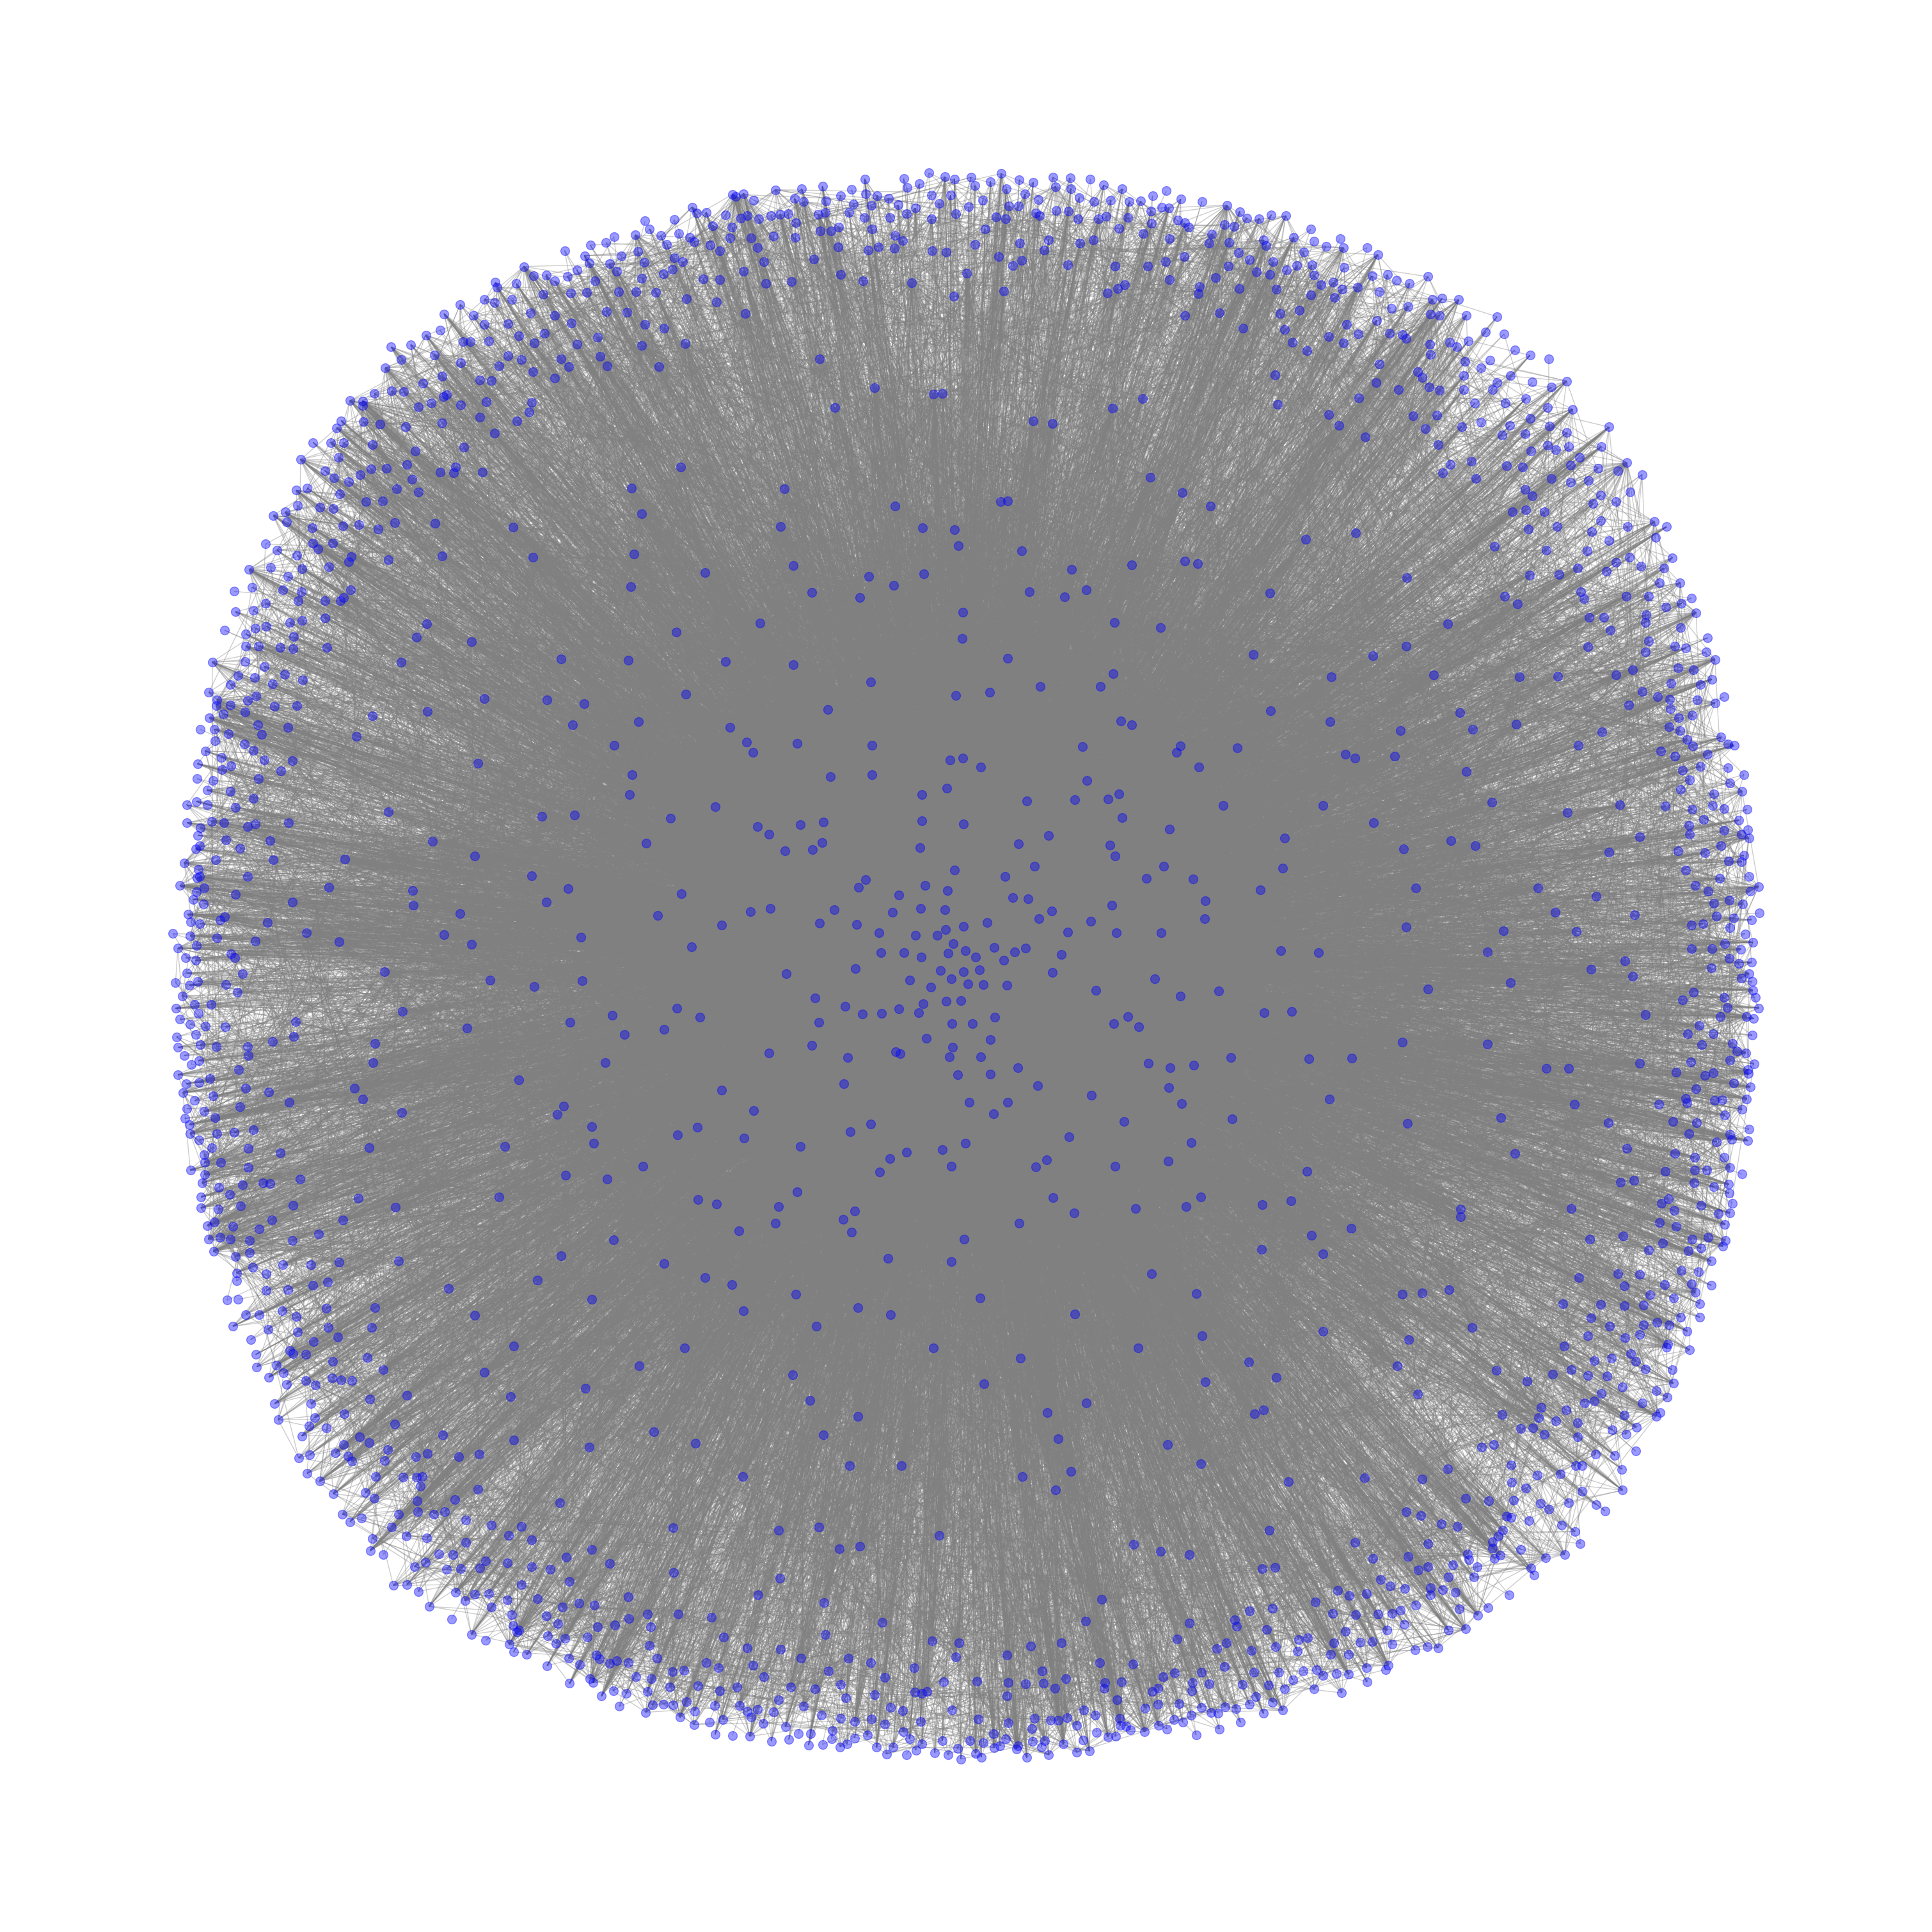

In [43]:
#Calcola il layout
pos = nx.spring_layout(G, k=1, seed=42)  

plt.figure(figsize=(30, 30))  
nx.draw(G, pos, with_labels=False, node_size=100, node_color='blue', edge_color='gray', alpha=0.4)  
plt.show()

**METODO PER IL CALCOLO DELLE STATISTICHE INTRA-CLUSTER**

Il seguente metodo è utilizzato per calcolare la media, per gli attributi di nodo numerici, e la moda, per gli attributi di nodo binari, sui nodi appartenenti ad una comunità, in maniera da mostrare la differenza tra esse in termini degli attributi.
I parametri utilizzati sono:
- data: Dataframe contenente gli attributi dei nodi del grafo;
- labels: array con le etichette delle comunità assegnate ai nodi da un metodo di Comunity Detection;
- numerical_cols: lista delle colonne di data contenenti gli attributi numerici;
- binary_cols: lista delle colone di data contenenti gli attributi binari;

Il metodo restituisce un dataframe con le statistiche per ciascuna comunità

In [10]:
import numpy as np
from scipy import stats

def calculate_cluster_statistics(data, labels, numerical_cols, binary_cols):
    #Aggiunta dell'informazione del cluster ai dati
    data['cluster'] = labels
    
    result = []
    
    for cluster in set(labels):  
        cluster_data = data[data['cluster'] == cluster]
        
        #Calcolo della media degli attributi numerici
        numerical_means = cluster_data[numerical_cols].mean()
        
        #Calcolo della moda degli attributi binari
        binary_modes = cluster_data[binary_cols].mode().iloc[0] 
        
        #Unione dei risultati in un dizionario
        cluster_summary = {f"{col}_mean": numerical_means[col] for col in numerical_cols}
        cluster_summary.update({f"{col}_mode": binary_modes[col] for col in binary_cols})
        
        result.append(cluster_summary)

    #Creazione del DataFrame con i risultati
    summary_df = pd.DataFrame(result)

    return summary_df


**COMMUNITY DETECTION BASATO SULLA TOPOLOGIA DELLA RETE**

**DISTANCE-BASED CLUSTERING**

Il primo approccio di community detection consiste in un clustering basato sulla distanza tra i nodi. In particolare, verrà utilizzato, a questo scopo, l'Agglomerative Hierarchical Clustering.

In [3]:
import numpy as np
from scipy.spatial.distance import squareform
import scipy.cluster.hierarchy as sch
import math

#calcolo della matrice delle distanze di tutte le coppie di nodi
distance_matrix = nx.floyd_warshall_numpy(G) #il metodo calcola la distanza minima tra ogni coppia di nodi

#conversione della matrice delle distanze in forma compatta
condensed_distance_matrix = squareform(distance_matrix)

#algoritmo di hierarchical clustering
linkage_matrix = sch.linkage(condensed_distance_matrix, method='single') #con single si indica la distanza minima tra cluster

#clustering
clusters = sch.fcluster(linkage_matrix, t=50, criterion='maxclust')

#numero di cluster creati
number_of_clusters = len(np.unique(clusters))
print(number_of_clusters)

1


Dal clustering con single linkage, che utilizza la distanza minima tra i nodi, viene restituito sempre un solo cluster. Questo sta ad indicare che i nodi sono molto vicini tra di loro, il che impedisce all'algoritmo di separare i nodi in cluster diversi. Proviamo, quindi, ad utilizzare un tipo diverso di linkage, ovvero il complete linkage.

In [4]:
#algoritmo di hierarchical clustering
linkage_matrix = sch.linkage(condensed_distance_matrix, method='complete') #con complete si indica la distanza massima tra cluster

#effettuiamo il clustering
clusters = sch.fcluster(linkage_matrix, t=50, criterion='maxclust')

#Numero di cluster creati
number_of_clusters = len(np.unique(clusters))
print(number_of_clusters)

23


In questo caso si ha la creazione di 23 cluster nel caso del complete linkage. Possiamo procedere, quindi, con la rappresentazione di questi cluster.

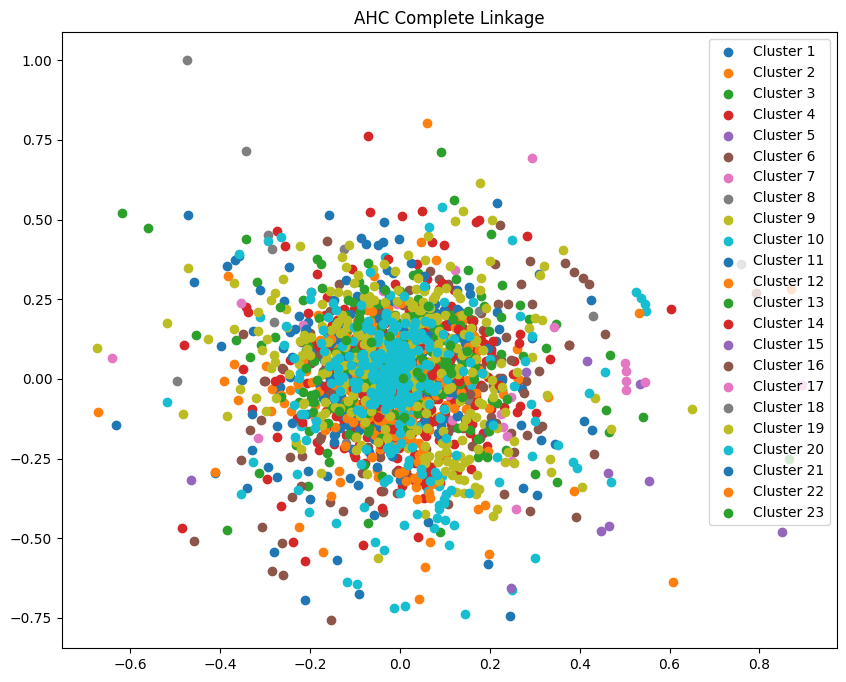

In [7]:
import networkx as nx
from sklearn.decomposition import PCA

#posizione dei nodi nel layout
pos = nx.spring_layout(G, seed=42)

#Associazione dei nodi al cluster corrispondente
node_clusters = {node: clusters[i] for i, node in enumerate(G.nodes())}
node_positions = np.array([pos[node] for node in G.nodes()])

plt.figure(figsize=(10, 8))

# Assegnamento di un colore per ciascun cluster
for i in np.unique(clusters):
    cluster_nodes = [node for node, cluster_id in node_clusters.items() if cluster_id == i]
    cluster_positions = node_positions[[list(G.nodes()).index(node) for node in cluster_nodes]]
    plt.scatter(cluster_positions[:, 0], cluster_positions[:, 1], label=f"Cluster {i}")

plt.title("AHC Complete Linkage")
plt.legend()
plt.show()

Segue un istogramma utilizzato per mostrare la differenza tra i diversi cluster, in base al numero di nodi che essi contengono.

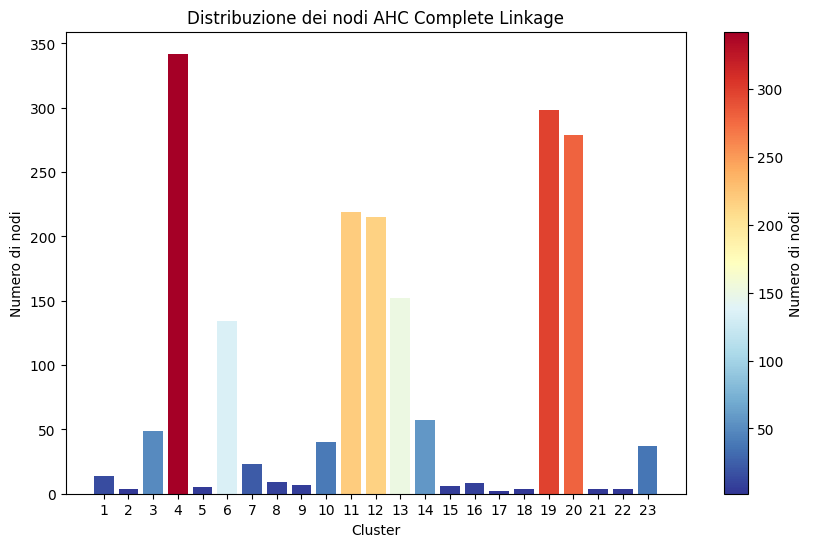

In [8]:
#Contwggio del numero di nodi per ciascun cluster
cluster_counts = {i: np.sum(clusters == i) for i in np.unique(clusters)}

#Estrazione dei dati per il grafico a barre
cluster_labels = list(cluster_counts.keys())
node_counts = list(cluster_counts.values())

#Creazione di una colormap che va dal rosso (molti nodi) al blu (pochi nodi)
norm = plt.Normalize(min(node_counts), max(node_counts))  #Normalizza i dati
colors = plt.cm.RdYlBu_r(norm(node_counts))  #colormap invertita


plt.figure(figsize=(10, 6))
bars = plt.bar(cluster_labels, node_counts, color=colors)

plt.xlabel('Cluster')
plt.ylabel('Numero di nodi')
plt.title('Distribuzione dei nodi AHC Complete Linkage')
plt.xticks(cluster_labels)

cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='RdYlBu_r', norm=norm), ax=plt.gca())
cbar.set_label('Numero di nodi')

plt.show()

A questo punto, mostriamo le statistiche di ciascun cluster utilizzando la funzione calculate_cluster_statistics definita in precedenza.

In [11]:
numerical_cols = ['views', 'days']  #colonne numeriche
binary_cols = ['mature', 'partner']  #colonne binarie

cluster_statistics = calculate_cluster_statistics(features, clusters, numerical_cols, binary_cols)

print(cluster_statistics)

      views_mean    days_mean  mature_mode  partner_mode
0   2.676305e+05  1051.000000        False         False
1   2.158650e+04  1222.500000         True         False
2   7.690286e+05  1437.367347        False         False
3   4.054985e+05  1336.397661        False         False
4   1.347020e+05  1756.200000         True         False
5   5.885329e+05  1318.141791        False         False
6   1.462779e+05  1333.043478        False         False
7   5.391286e+05  1018.222222         True         False
8   1.016976e+06  1487.142857        False         False
9   2.633795e+04  1524.175000        False         False
10  2.670083e+05  1323.931507        False         False
11  1.949868e+05  1283.916279        False         False
12  4.510985e+05  1263.526316        False         False
13  9.836438e+05  1251.877193        False         False
14  1.071198e+05  1443.333333        False         False
15  3.965262e+04  1313.875000        False         False
16  1.706315e+05  1711.500000  

**DEGREE-BASED COMMUNITY DETECTION**

In questo caso viene utilizzato il Clique Percolation Method, dato che l'algoritmo Brute-force Clique Identification non è efficiente per reti grandi. 



In [12]:
from itertools import combinations

#metodo che consente di individuare i k-clique di un grafo
def build_epsilon(cliques, k):
    epsilon = set()
    
    #Combinazioni di clique da confrontare
    for clique1, clique2 in combinations(cliques, 2):
        #intersezione dei due clique
        common_nodes = set(clique1).intersection(clique2)
        
        #Se l'intersezione ha esattamente k-1 nodi, si aggiunge la coppia
        if len(common_nodes) == k-1:
            epsilon.add((clique1, clique2))
    
    return epsilon

In [5]:
#Si trovano tutte i clique nel grafo G
cliques = list(nx.find_cliques(G))

#filtraggio dei clique totali per ottenere solo quelli della dimensione scelta
k=16
cliques_of_size_k = [tuple(clique) for clique in cliques if len(clique) == k]

#costruzione dell'insieme di archi epsilon
epsilon = build_epsilon(cliques_of_size_k, k)

#creazione del grafo Gc
Gc = nx.Graph()

#i clique sono aggiunti come nodi nel grafo
Gc.add_nodes_from(cliques_of_size_k)

#Aggiunta degli archi
Gc.add_edges_from(epsilon)

print(f"|C| = {Gc.number_of_nodes()}")
print(f"|Epsilon| = {Gc.number_of_edges()}")



|C| = 124
|Epsilon| = 172


Il valore di k è stato scelto empiricamente al fine di ottenere una nuova rete con un numero di nodi e archi adeguato, anche ai fini della visualizzazione.

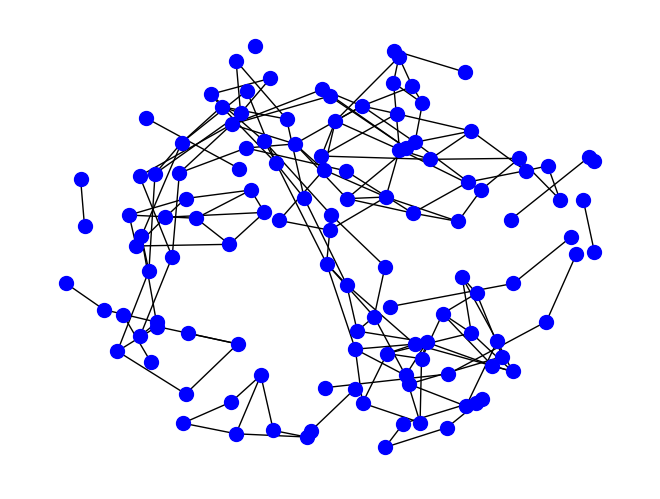

In [116]:
#rappresentazione del grafo Gc
pos = nx.spring_layout(Gc, k=0.3, iterations=40)
nx.draw(Gc, pos, with_labels=False, node_size=100, node_color='blue', font_size=8)
plt.show()

L'ultimo passo di CPM è l'individuazione delle componenti connesse del grafo Gc. In più, si possono rimuovere le componenti isolate del grafo, che da un punto di vista topologico non hanno una grossa influenza

In [117]:
# Troviamo le componenti isolate
isolated_nodes = list(nx.isolates(Gc))

# Rimuovi i nodi isolati dal grafo
Gc.remove_nodes_from(isolated_nodes)
print(f"|C| = {Gc.number_of_nodes()}")

|C| = 121


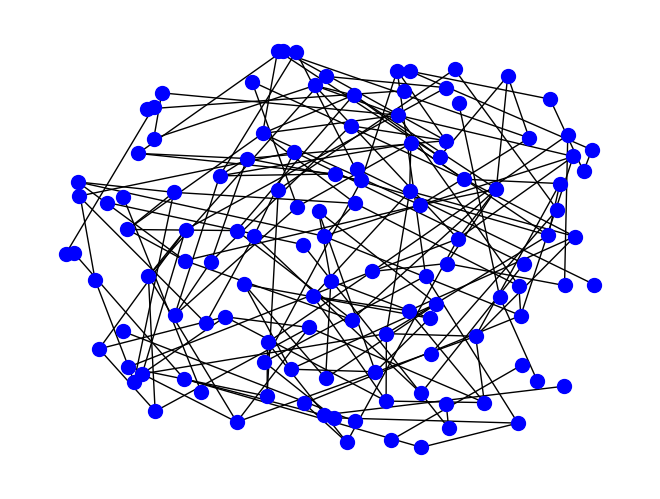

In [114]:
#rappresentazione del grafo Gc
pos = nx.spring_layout(Gc, k=0.6, iterations=40)
nx.draw(Gc, pos, with_labels=False, node_size=100, node_color='blue', font_size=8)
plt.show()

**MODULARITY-BASED COMMUNITY DETECTION**

In questo caso è stato utilizzato il metodo di Louvain per effettuare la community detection.

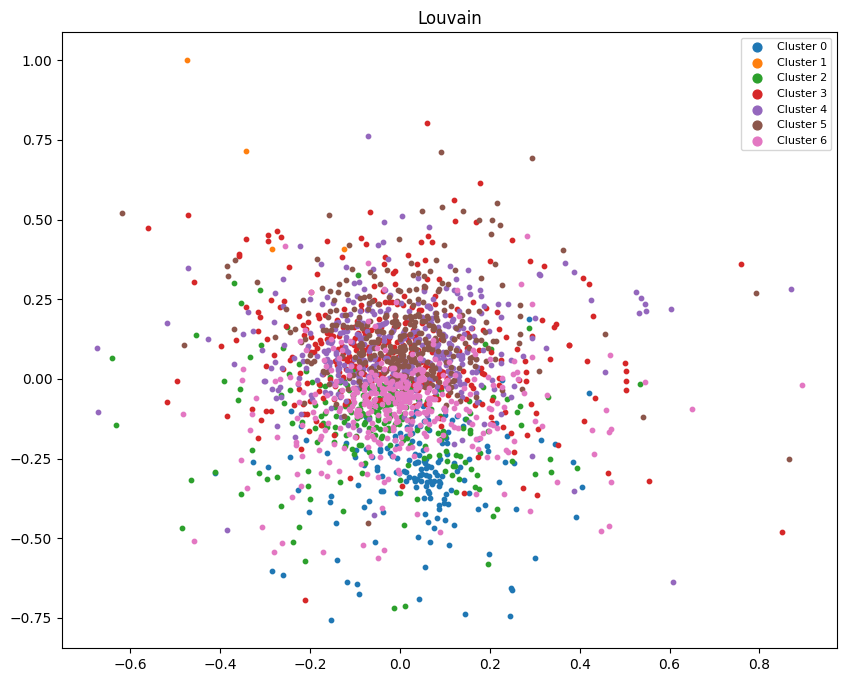

In [13]:
import networkx as nx
import community as community_louvain

#Calcolo delle comunità utilizzando Louvain
partition = community_louvain.best_partition(G)

#posizione dei nodi con un layout
pos = nx.spring_layout(G, seed=42)

#Associazione di ogni nodo al cluster corrispondente
node_clusters = {node: cluster for node, cluster in partition.items()}

node_positions = np.array([pos[node] for node in G.nodes()])

plt.figure(figsize=(10, 8))

#Assegnamento di un colore per ciascun cluster
unique_clusters = np.unique(list(partition.values()))
for cluster_id in unique_clusters:
    cluster_nodes = [node for node, cluster in node_clusters.items() if cluster == cluster_id]
    cluster_positions = np.array([pos[node] for node in cluster_nodes])
    plt.scatter(cluster_positions[:, 0], cluster_positions[:, 1], label=f"Cluster {cluster_id}", s=10)


plt.title("Louvain")
plt.legend(markerscale=2, fontsize=8)
plt.show()

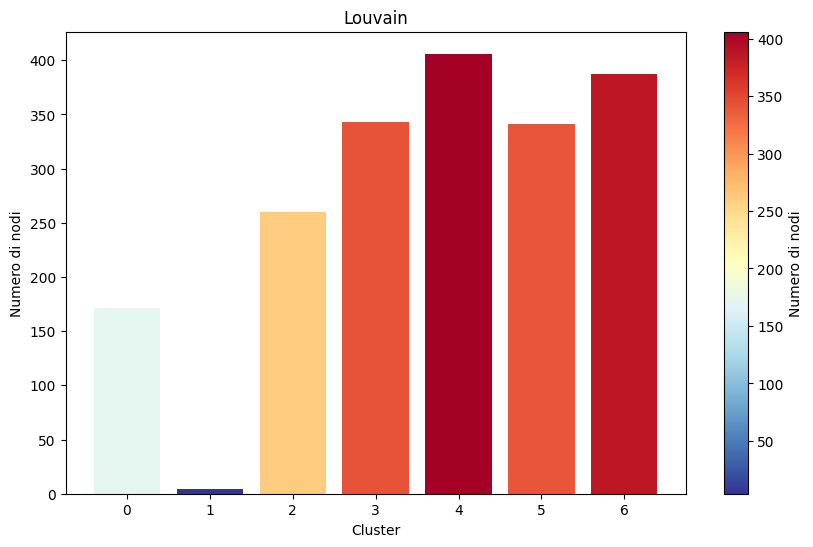

In [14]:
#Conteggio del numero di nodi per ciascun cluster
cluster_counts = {cluster: list(partition.values()).count(cluster) for cluster in set(partition.values())}

#Estrazione dei dati per il grafico a barre
cluster_labels = list(cluster_counts.keys())
node_counts = list(cluster_counts.values())

#Creazione di una colormap che va dal rosso (molti nodi) al blu (pochi nodi)
norm = plt.Normalize(min(node_counts), max(node_counts))  
colors = plt.cm.RdYlBu_r(norm(node_counts))  #colormap invertita

plt.figure(figsize=(10, 6))
bars = plt.bar(cluster_labels, node_counts, color=colors)

# Aggiungi etichette e titolo
plt.xlabel('Cluster')
plt.ylabel('Numero di nodi')
plt.title('Louvain')
plt.xticks(cluster_labels)


cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='RdYlBu_r', norm=norm), ax=plt.gca())
cbar.set_label('Numero di nodi')

plt.show()

In [15]:
#uso le etichette generate da Louvain per calcolare le statistiche
labels = np.array([partition[node] for node in G.nodes()])

numerical_cols = ['views', 'days']  # Colonne numeriche
binary_cols = ['mature', 'partner']  # Colonne binarie

#Calcolo delle statistiche per ciascun cluster
statistics = calculate_cluster_statistics(features, labels, numerical_cols, binary_cols)

print(statistics)

      views_mean    days_mean  mature_mode  partner_mode
0  350440.391813  1369.526316        False         False
1  199572.000000  1735.250000        False         False
2  686083.169231  1329.361538        False         False
3  753913.446064  1322.912536        False         False
4  274820.009852  1296.152709        False         False
5  200870.733138  1333.469208        False         False
6  267937.731266  1334.749354        False         False


**LABEL PROPAGATION-BASED COMMUNITY DETECTION**

In questo caso viene utilizzata una implementazione già presente all'interno della libreria nx per la label propagation.

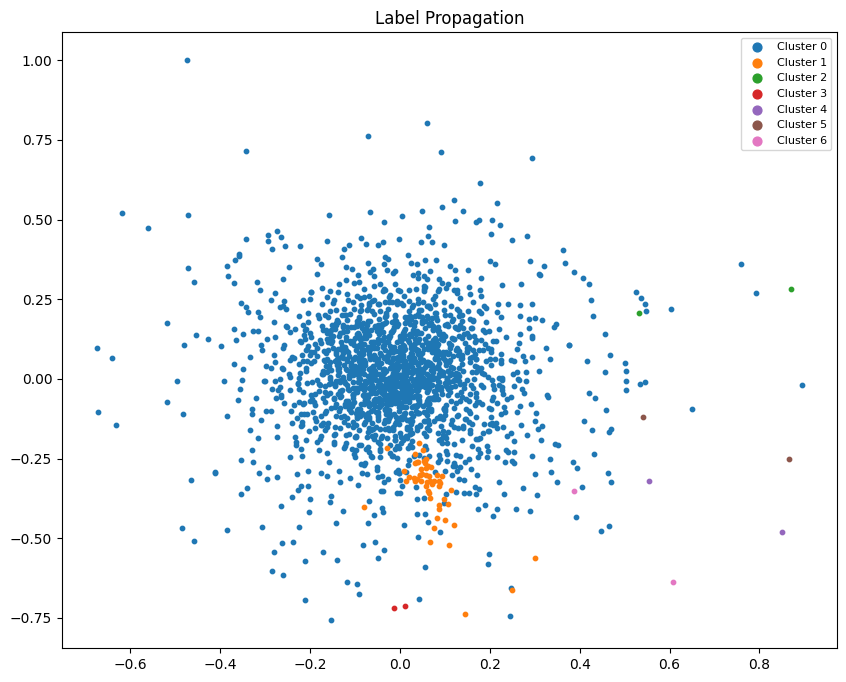

In [16]:
from networkx.algorithms.community import label_propagation_communities

#Calcolo delle comunità usando Label Propagation 
communities = label_propagation_communities(G)

#Assegnamento a ciascun nodo del suo cluster
node_clusters = {}
for i, community in enumerate(communities):
    for node in community:
        node_clusters[node] = i

#posizione dei nodi con un layout 
pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(10, 8))

#Assegnamento di un colore per ciascun cluster
for cluster_id in set(node_clusters.values()):
    cluster_nodes = [node for node, cluster in node_clusters.items() if cluster == cluster_id]
    cluster_positions = [pos[node] for node in cluster_nodes]
    cluster_positions = np.array(cluster_positions)
    plt.scatter(cluster_positions[:, 0], cluster_positions[:, 1], label=f"Cluster {cluster_id}", s=10)

plt.title("Label Propagation")
plt.legend(markerscale=2, fontsize=8)
plt.show()

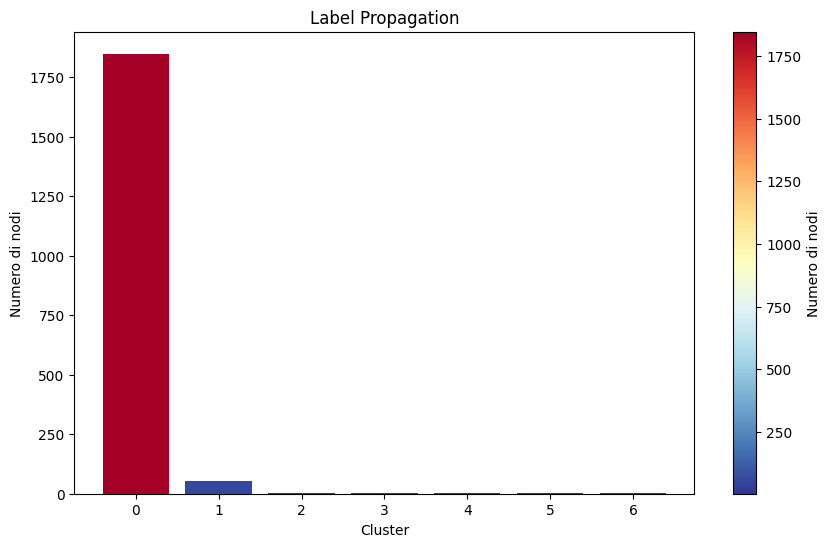

In [18]:
#Conteggio del numero di nodi per ciascun cluster
cluster_counts = {i: len(cluster) for i, cluster in enumerate(communities)}

#Estrazione dei dati per il grafico a barre
cluster_labels = list(cluster_counts.keys())
node_counts = list(cluster_counts.values())

#Creazione di una colormap che va dal rosso (molti nodi) al blu (pochi nodi)
norm = plt.Normalize(min(node_counts), max(node_counts)) 
colors = plt.cm.RdYlBu_r(norm(node_counts))  #colormap invertita

plt.figure(figsize=(10, 6))
bars = plt.bar(cluster_labels, node_counts, color=colors)

plt.xlabel('Cluster')
plt.ylabel('Numero di nodi')
plt.title('Label Propagation')
plt.xticks(cluster_labels)

cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='RdYlBu_r', norm=norm), ax=plt.gca())
cbar.set_label('Numero di nodi')

plt.show()

In [19]:
#uso le etichette generate da LP per calcolare le statistiche
node_labels = np.array([next(i for i, community in enumerate(communities) if node in community) for node in G.nodes()])

numerical_cols = ['views', 'days']  # Colonne numeriche
binary_cols = ['mature', 'partner']  # Colonne binarie

#Calcolo delle statistiche per ciascun cluster usando la funzione
statistics = calculate_cluster_statistics(features, node_labels, numerical_cols, binary_cols)

print(statistics)


      views_mean    days_mean  mature_mode  partner_mode
0  398377.599026  1323.667749        False         False
1  824029.685185  1443.962963        False         False
2   15783.500000   329.000000        False         False
3    7047.000000  1138.500000        False         False
4  333381.000000  2074.000000         True         False
5    3854.000000  1394.000000        False         False
6   21870.000000  2019.500000         True         False


**ATTRIBUTE-BASED COMMUNITY DETECTION**

L'ultimo approccio di community detection utilizzato è basato sugli attributi dei nodi presenti all'interno del grafo.

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

data = features[['new_id', 'views','days','mature','partner']]
print(data.head())

#Controllo valori mancanti
print(data.isnull().sum())

#Standardizzazione delle colonne numeriche
scaler = StandardScaler()
data[['views', 'days']] = scaler.fit_transform(data[['views', 'days']])

#Trasformazione degli attributi binari in 0 e 1
data['mature'] = data['mature'].astype(int)
data['partner'] = data['partner'].astype(int)

print(data.head())

#dati utilizzati per il calcolo della similarità tra gli attributi dei nodi (l'id è escluso)
data_similarity = data.drop(columns=['new_id'])

similarity_matrix = cosine_similarity(data_similarity)
print(np.round(similarity_matrix, 2))

   new_id   views  days  mature  partner
0    1706  929459  1943   False     True
1    1273   11194  1633   False    False
2     313    2850   632   False    False
3    1570    3422   906    True    False
4     800      71   267   False    False
new_id     0
views      0
days       0
mature     0
partner    0
dtype: int64
   new_id     views      days  mature  partner
0    1706  0.150785  0.899049       0        1
1    1273 -0.115105  0.446299       0        0
2     313 -0.117521 -1.015647       0        0
3    1570 -0.117355 -0.615474       1        0
4     800 -0.118325 -1.548724       0        0
[[ 1.    0.62 -0.67 ...  0.44  0.97 -0.67]
 [ 0.62  1.   -0.93 ... -0.33  0.43 -0.91]
 [-0.67 -0.93  1.   ...  0.36 -0.47  1.  ]
 ...
 [ 0.44 -0.33  0.36 ...  1.    0.65  0.36]
 [ 0.97  0.43 -0.47 ...  0.65  1.   -0.47]
 [-0.67 -0.91  1.   ...  0.36 -0.47  1.  ]]


/tmp/ipykernel_23/2849968648.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[['views', 'days']] = scaler.fit_transform(data[['views', 'days']])
/tmp/ipykernel_23/2849968648.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['mature'] = data['mature'].astype(int)
/tmp/ipykernel_23/2849968648.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

In [22]:
#Crezione di un grafo vuoto
G_w = nx.Graph()

#Aggiunta dei nodi al grafo 
for idx, row in data.iterrows():
    G_w.add_node(row['new_id'], **row.to_dict())

#Aggiunta degli archi basati sulla similarità
for i in range(len(data)):
    for j in range(i + 1, len(data)):
        similarity = similarity_matrix[i, j]  #similarità tra i nodi i e j
        if similarity > 0.9:  #Solo se la similarità è maggiore di 0.7 l'arco viene aggiunto al grafo
            G_w.add_edge(data.iloc[i]['new_id'], data.iloc[j]['new_id'], weight=similarity)

print(f"Numero di nodi: {G_w.number_of_nodes()}")
print(f"Numero di archi: {G_w.number_of_edges()}")

Numero di nodi: 1912
Numero di archi: 315498


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

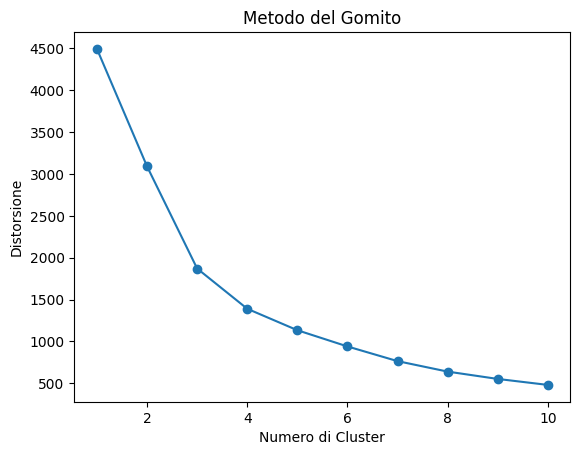

In [23]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

#Estrazione delle caratteristiche dei nodi dal dataframe
node_features = data[['views', 'days', 'mature', 'partner']].values

#Lista per memorizzare la distorsione per ogni numero di cluster
distortions = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(node_features)
    distortions.append(kmeans.inertia_)  # La distorsione (somma delle distanze quadrate)

#Plot del metodo del gomito
plt.plot(range(1, 11), distortions, marker='o')
plt.title("Metodo del Gomito")
plt.xlabel("Numero di Cluster")
plt.ylabel("Distorsione")
plt.show()


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/tmp/ipykernel_23/2745928763.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(set(kmeans.labels_)))


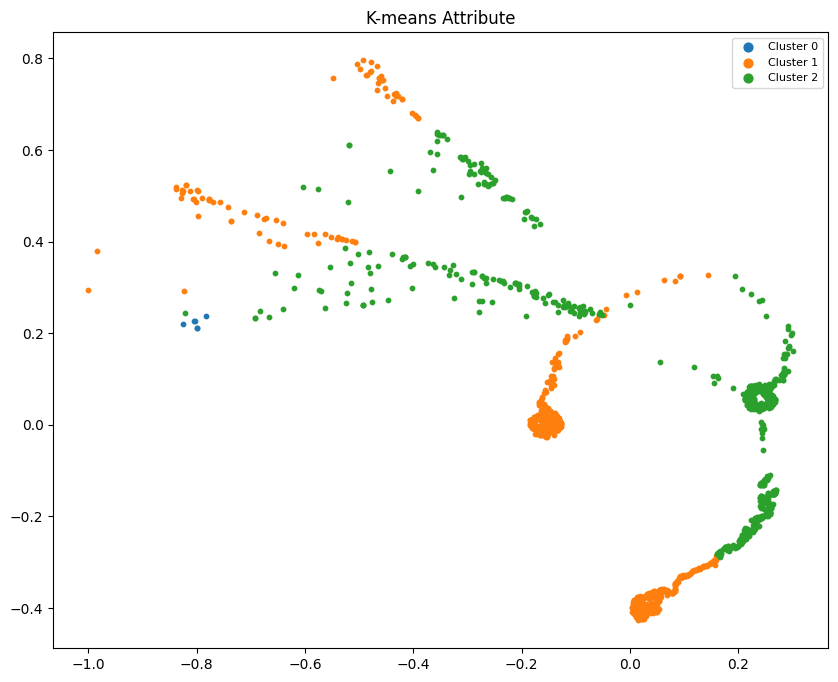

In [24]:
#Estrazione delle caratteristiche dei nodi dal dataframe
node_features = data[['views', 'days', 'mature', 'partner']].values 

# Eseguiamo K-means con un numero di cluster che decidiamo (per esempio 3)
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(node_features)

#Aggiunta dell'etichetta del cluster a ciascun nodo
for idx, node in enumerate(G_w.nodes()):
    G_w.nodes[node]['cluster'] = kmeans.labels_[idx]

#Assegnamento a ciascun nodo del colore del suo cluster
colors = [G_w.nodes[node]['cluster'] for node in G_w.nodes()]

#posizione dei nodi con un layout 
pos = nx.spring_layout(G_w, seed=42)

plt.figure(figsize=(10, 8))

colors = plt.cm.get_cmap('tab20', len(set(kmeans.labels_)))

for cluster_id in set(kmeans.labels_):
    cluster_nodes = [node for node in G_w.nodes if G_w.nodes[node]['cluster'] == cluster_id]
    cluster_positions = np.array([pos[node] for node in cluster_nodes])
    
    #Aggiunta del nodo al plot
    plt.scatter(cluster_positions[:, 0], cluster_positions[:, 1], label=f"Cluster {cluster_id}", s=10)

plt.title("K-means Attribute")
plt.legend(markerscale=2, fontsize=8)
plt.show()


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


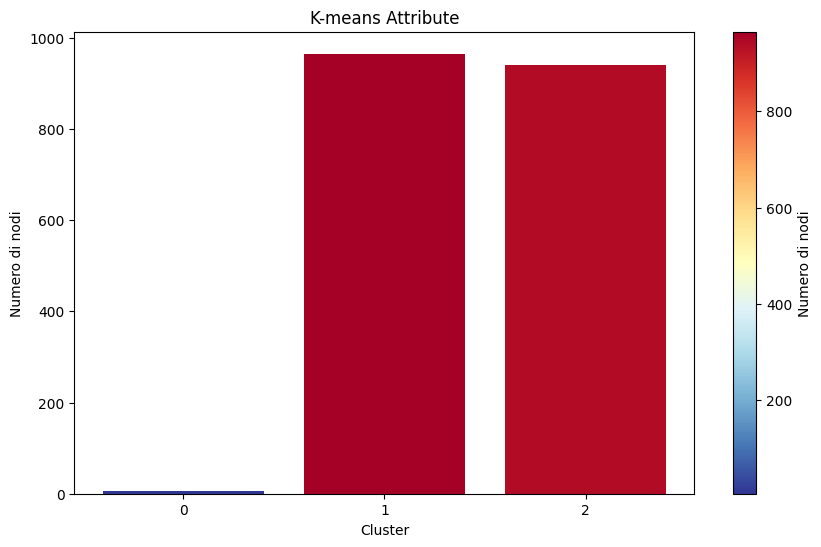

In [25]:
#Estrazione delle caratteristiche dei nodi dal dataframe
node_features = data[['views', 'days', 'mature', 'partner']].values 

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(node_features)

#Aggiunta dell'etichetta del cluster a ciascun nodo
for idx, node in enumerate(G_w.nodes()):
    G_w.nodes[node]['cluster'] = kmeans.labels_[idx]

#Conteggio del numero di nodi per ciascun cluster
cluster_counts = {i: list(kmeans.labels_).count(i) for i in set(kmeans.labels_)}

#Estrazione dei dati per il grafico a barre
cluster_labels = list(cluster_counts.keys())
node_counts = list(cluster_counts.values())

#Creazione di una colormap che va dal rosso (molti nodi) al blu (pochi nodi)
norm = plt.Normalize(min(node_counts), max(node_counts)) 
colors = plt.cm.RdYlBu_r(norm(node_counts))  #colormap invertita

plt.figure(figsize=(10, 6))
bars = plt.bar(cluster_labels, node_counts, color=colors)

# Aggiungi etichette e titolo
plt.xlabel('Cluster')
plt.ylabel('Numero di nodi')
plt.title('K-means Attribute')
plt.xticks(cluster_labels)

cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='RdYlBu_r', norm=norm), ax=plt.gca())
cbar.set_label('Numero di nodi')

plt.show()


In [25]:
#Ottengo le etichette di cluster per ciascun nodo
node_labels = kmeans.labels_

# Definisci le colonne numeriche e binarie (ad esempio)
numerical_cols = ['views', 'days']  # Colonne numeriche
binary_cols = ['mature', 'partner']  # Colonne binarie

# Calcola le statistiche per ciascun cluster usando la funzione
statistics = calculate_cluster_statistics(features, node_labels, numerical_cols, binary_cols)

# Stampa le statistiche calcolate
print(statistics)

     views_mean    days_mean  mature_mode  partner_mode
0  4.974280e+07  2039.500000        False          True
1  9.242231e+04   751.123316        False         False
2  4.185111e+05  1913.869288        False         False
